In [1]:
import torch
import torch.optim as optim
import pickle
from library_models import *
from library_data import *
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns

In [2]:
class Fakeargs:
    pass
args = Fakeargs()
args.model = "Jodie"
args.network = "public_dataset_ready_reduced"
args.gpu = -1
args.embedding_dim = 8
args.train_proportion = 0.8
args.state_change = True
args.epoch = 3
args.datapath = "data/%s.csv" % args.network

In [3]:
# LOAD NETWORK
[user2id, user_sequence_id, user_timediffs_sequence, user_previous_itemid_sequence, \
 item2id, item_sequence_id, item_timediffs_sequence, \
 timestamp_sequence, \
 feature_sequence, \
 y_true] = load_network(args)
num_interactions = len(user_sequence_id)
num_features = len(feature_sequence[0])
num_users = len(user2id)
num_items = len(item2id) + 1
true_labels_ratio = len(y_true)/(sum(y_true)+1)
print("*** Network statistics:\n  %d users\n  %d items\n  %d interactions\n  %d/%d true labels ***\n\n" % (num_users, num_items, num_interactions, sum(y_true), len(y_true)))

#define parameters of training
train_proportion = 0.8

# SET TRAIN, VALIDATION, AND TEST BOUNDARIES
train_end_idx = validation_start_idx = int(num_interactions * args.train_proportion)
test_start_idx = int(num_interactions * (args.train_proportion + 0.1))
test_end_idx = int(num_interactions * (args.train_proportion + 0.2))

# SET BATCHING TIMESPAN
'''
Timespan indicates how frequently the model is run and updated.
All interactions in one timespan are processed simultaneously.
Longer timespans mean more interactions are processed and the training time is reduced, however it requires more GPU memory.
At the end of each timespan, the model is updated as well. So, longer timespan means less frequent model updates.
'''
timespan = timestamp_sequence[-1] - timestamp_sequence[0]
tbatch_timespan = timespan / 500

# INITIALIZE MODEL PARAMETERS
model = JODIE(args, num_features, num_users, num_items).cuda()
weight = torch.Tensor([1,true_labels_ratio]).cuda()
crossEntropyLoss = nn.CrossEntropyLoss(weight=weight)
MSELoss = nn.MSELoss()

# INITIALIZE MODEL
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# LOAD THE MODEL
model, optimizer, user_embeddings_dystat, item_embeddings_dystat, user_embeddings_timeseries, item_embeddings_timeseries, train_end_idx_training = load_model(model, optimizer, args, args.epoch)



**** Loading public_dataset_ready_reduced network from file: data/public_dataset_ready_reduced.csv ****
Formating item sequence
Formating user sequence
Scaling timestamps
*** Network loading completed ***


*** Network statistics:
  39 users
  43 items
  253973 interactions
  22215/253973 true labels ***


*** Initializing the JODIE model ***
Initializing user and item embeddings
Initializing user and item RNNs
Initializing linear layers
*** JODIE initialization complete ***


Loading saved embeddings and model: ./saved_models/public_dataset_ready_reduced/checkpoint.Jodie.ep3.tp0.8.pth.tar


In [8]:
USER = 33 # np.random.randint(0, max(user_sequence_id))
print(USER)
user_embeddings = user_embeddings_timeseries[np.where(np.array(user_sequence_id)==USER)[0],:]
print(user_embeddings.shape)

33
torch.Size([80, 8])


<AxesSubplot:>

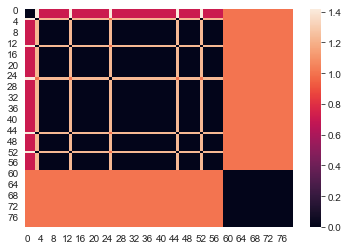

In [9]:
sns.heatmap(euclidean_distances(user_embeddings.cpu()))

## Results of certain users
Users with good results - {18, 33, 23, 24, 29, 4}
Users with weird results - {19,}
Users with too many interactions - will do downsampling on them next to recover some information

In [10]:
def subsampling_function(user_embeddings):
    '''
    Subsample if there are too many user embeddings for visialization.
    Subsampling is done so that there are around 1000 interactions max.
    '''
    if user_embeddings.shape[0] < 1500:
        print("Subsampling not neeeded")
        return user_embeddings
    subsampling_factor = int(user_embeddings.shape[0]/1000)
    print(f"Subsampling by a factor of {subsampling_factor}")
    return user_embeddings[::subsampling_factor,:]

In [11]:
#Examples of users with too many interactions = {0,1,2..}
USER = 12
user_embeddings = user_embeddings_timeseries[np.where(np.array(user_sequence_id)==USER)[0],:]
print(user_embeddings.shape)
#subsample by every 50th
user_embeddings = subsampling_function(user_embeddings)
print(user_embeddings.shape)

torch.Size([4782, 8])
Subsampling by a factor of 4
torch.Size([1196, 8])


<AxesSubplot:>

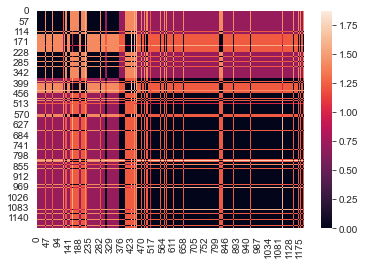

In [12]:
pairwise_dist = euclidean_distances(user_embeddings.cpu())
sns.heatmap(pairwise_dist)

# Results quick summary
The results are similar for users with a lot of interactions as well for users with only limited amount. It seems like the embeddings usually keeps around the same space for untill a while before the end.

The phase of comparing embeddings of different users ensues next

In [13]:
#pick two random users
rand_user1, rand_user2 = np.random.randint(0, max(user_sequence_id),size=2)
#pick out their sequences
user1_embeddings = subsampling_function(user_embeddings_timeseries[np.where(np.array(user_sequence_id)==rand_user1)[0],:])
user2_embeddings = subsampling_function(user_embeddings_timeseries[np.where(np.array(user_sequence_id)==rand_user2)[0],:])
print(rand_user1, rand_user2,user1_embeddings.shape, user2_embeddings.shape)

Subsampling not neeeded
Subsampling not neeeded
33 6 torch.Size([80, 8]) torch.Size([324, 8])


<AxesSubplot:>

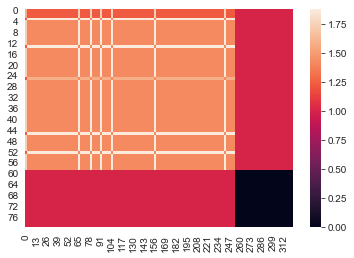

In [14]:
sns.heatmap(euclidean_distances(user1_embeddings.cpu(), user2_embeddings.cpu()))

## Results without taking into account the timestamps
Good pairs to see various outcomes - [[34,16],[11,30], [6,2],[28,26], [17,12], []]
Bad pairs - [[29,32],[21,34]]
Next is a section taking into account the timestamps and comparing embeddings in the same timestamp

## Let's pick a given number of timestamps throughout the entire time (I am going to try 50) and track the embeddings of picked assets in these timestamps. The timestamps will be uniformly distributed throughout the timestamps sequence. !!!(which does not imply uniformly distributed in time)!!!

In [15]:
number_of_timepoints = 50
subsampling_factor = int(len(timestamp_sequence)/number_of_timepoints)
reduced_timestamps_seq = timestamp_sequence[::subsampling_factor]
print(len(reduced_timestamps_seq))
print(reduced_timestamps_seq)

51
[   0.  185.  406.  601.  774.  957. 1159. 1355. 1566. 1795. 2020. 2234.
 2434. 2634. 2835. 3041. 3235. 3339. 3492. 3665. 3849. 4027. 4214. 4404.
 4573. 4741. 4914. 5090. 5272. 5465. 5656. 5843. 6052. 6243. 6434. 6660.
 6880. 7087. 7303. 7520. 7756. 7958. 8147. 8356. 8570. 8792. 9026. 9269.
 9506. 9736. 9969.]


In [16]:
def pick_the_embeddings(user_embeddings, timestamp_sequence, user_timestamps_sequence):
    '''
    user_embeddings: user embeddings series
    timestamp_sequence: list with timestamps fo required embeddings
    user_timestamps_sequence: timestamps of interaction of the user
    '''
    indexes = set()
    ret_embeddings = np.zeros((1,user_embeddings.shape[1]))
    for index, timestamp in enumerate(timestamp_sequence):
        if timestamp < user_timestamps_sequence[0]:
            ret_embeddings = np.vstack((ret_embeddings, user_embeddings[0,:]))
            indexes.add(0)
        elif timestamp > user_timestamps_sequence[-1]:
            ret_embeddings = np.vstack((ret_embeddings, user_embeddings[-1,:]))
            indexes.add(user_timestamps_sequence[-1])
        else:
            for index_user, timestamp_user in enumerate(user_timestamps_sequence[:-1]):
                if timestamp_user  <= timestamp <= user_timestamps_sequence[index_user+1]:
                    ret_embeddings = np.vstack((ret_embeddings, user_embeddings[index_user,:]))
                    indexes.add(timestamp_user)
                    break
    print(f"Picked {len(indexes)} embeddings")
    return ret_embeddings[1:,:]

In [26]:
# choose 2 random users and get the required amount of embeddings
rand_user1, rand_user2 = np.random.randint(0, max(user_sequence_id),size=2)
user1_embeddings = user_embeddings_timeseries[np.where(np.array(user_sequence_id)==rand_user1)[0],:]
user2_embeddings = user_embeddings_timeseries[np.where(np.array(user_sequence_id)==rand_user2)[0],:]
print(f"User {rand_user1} has {user1_embeddings.shape[0]} interactions")
print(f"User {rand_user2} has {user2_embeddings.shape[0]} interactions")
user1_timestamps = timestamp_sequence[np.where(np.array(user_sequence_id)==rand_user1)[0]]
user2_timestamps = timestamp_sequence[np.where(np.array(user_sequence_id)==rand_user2)[0]]

User 34 has 62 interactions
User 29 has 65 interactions


Picked 18 embeddings
Picked 17 embeddings


<AxesSubplot:>

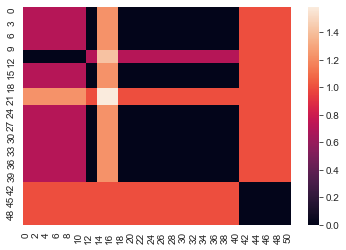

In [27]:
user1_timestamps_embeddings = pick_the_embeddings(user1_embeddings.cpu(), reduced_timestamps_seq, user1_timestamps)
user2_timestamps_embeddings = pick_the_embeddings(user2_embeddings.cpu(), reduced_timestamps_seq, user2_timestamps)
dist_matrix = euclidean_distances(user1_timestamps_embeddings, user2_timestamps_embeddings)
sns.heatmap(dist_matrix)

In [23]:
 1 print(f"The euclidian similarity measure over timestamps is: {np.sum(np.diag(dist_matrix))}")

The euclidian similarity measure over timestamps is: 12.247448504309734
